<a href="https://colab.research.google.com/github/shehabeldin-mohamed/Ecommerce_Analysis/blob/main/E_commerce_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Cleaning/Loading**

In [33]:
#import statements
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pyspark.sql import functions as fn
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType, LongType, TimestampType
from pyspark.sql.functions import col, split, when, lower, to_timestamp,trim
pd.options.display.float_format = "{:,.2f}".format

In [3]:
#mounting drive to get the dataset
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
#creating spark session
spark = SparkSession.builder \
    .appName("EcommerceAnalysis") \
    .config("spark.jars.packages", "org.postgresql:postgresql:42.7.2") \
    .getOrCreate()

print(f"The Spark version is {spark.version}")
print(f"App Name: {spark.conf.get('spark.app.name')}")

The Spark version is 4.0.1
App Name: EcommerceAnalysis


In [5]:
#Defining Schema to have consistent data types
schema = StructType([
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("product_id", LongType(), True),
    StructField("category_id", LongType(), True),
    StructField("category_code", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("price", FloatType(), True),
    StructField("user_id", LongType(), True),
    StructField("user_session", StringType(), True)
])

In [6]:
#creating Spark dataframe and loading the dataset
df = spark.read.schema(schema).format("csv").option("header","true").option("timestampFormat", "yyyy-MM-dd HH:mm:ss 'UTC'").load("/content/drive/MyDrive/Dataset/2019-Nov.csv")

In [7]:
#checking if dataframe has correct data types
df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: long (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_session: string (nullable = true)



In [8]:
#Showing 5 first rows to check if everything is working, and checking the dataset consists of how many rows
df.show(5)
df.count()

+-------------------+----------+----------+-------------------+--------------------+------+------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code| brand| price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+------+------+---------+--------------------+
|2019-11-01 00:00:00|      view|   1003461|2053013555631882655|electronics.smart...|xiaomi|489.07|520088904|4d3b30da-a5e4-49d...|
|2019-11-01 00:00:00|      view|   5000088|2053013566100866035|appliances.sewing...|janome|293.65|530496790|8e5f4f83-366c-4f7...|
|2019-11-01 00:00:01|      view|  17302664|2053013553853497655|                NULL| creed| 28.31|561587266|755422e7-9040-477...|
|2019-11-01 00:00:01|      view|   3601530|2053013563810775923|appliances.kitche...|    lg|712.87|518085591|3bfb58cd-7892-48c...|
|2019-11-01 00:00:01|      view|   1004775|2053013555631882655|electronics.smart...|xiaomi

67501979

In [9]:
#drop column category_id
df_dropped = df.drop("category_id")

In [10]:
#check if it is dropped
df_dropped.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_session: string (nullable = true)



In [11]:
#check if columns have null values and how many
df_dropped.select([fn.count(fn.when(fn.col(c).isNull(), c)).alias(c) for c in df_dropped.columns]).show()

+----------+----------+----------+-------------+-------+-----+-------+------------+
|event_time|event_type|product_id|category_code|  brand|price|user_id|user_session|
+----------+----------+----------+-------------+-------+-----+-------+------------+
|         0|         0|         0|     21898171|9218235|    0|      0|          10|
+----------+----------+----------+-------------+-------+-----+-------+------------+



In [12]:
#fill null values with 'unknown'
df_dropped_cleaned = df_dropped.fillna({"user_session": "unknown", "category_code":"unknown","brand":"unknown"})

In [13]:
#check if null values are filled
df_dropped_cleaned.select([fn.count(fn.when(fn.col(c).isNull(), c)).alias(c) for c in df_dropped_cleaned.columns]).show()

+----------+----------+----------+-------------+-----+-----+-------+------------+
|event_time|event_type|product_id|category_code|brand|price|user_id|user_session|
+----------+----------+----------+-------------+-----+-----+-------+------------+
|         0|         0|         0|            0|    0|    0|      0|           0|
+----------+----------+----------+-------------+-----+-----+-------+------------+



In [14]:
#show first 5
df_dropped_cleaned.show(5)

+-------------------+----------+----------+--------------------+------+------+---------+--------------------+
|         event_time|event_type|product_id|       category_code| brand| price|  user_id|        user_session|
+-------------------+----------+----------+--------------------+------+------+---------+--------------------+
|2019-11-01 00:00:00|      view|   1003461|electronics.smart...|xiaomi|489.07|520088904|4d3b30da-a5e4-49d...|
|2019-11-01 00:00:00|      view|   5000088|appliances.sewing...|janome|293.65|530496790|8e5f4f83-366c-4f7...|
|2019-11-01 00:00:01|      view|  17302664|             unknown| creed| 28.31|561587266|755422e7-9040-477...|
|2019-11-01 00:00:01|      view|   3601530|appliances.kitche...|    lg|712.87|518085591|3bfb58cd-7892-48c...|
|2019-11-01 00:00:01|      view|   1004775|electronics.smart...|xiaomi|183.27|558856683|313628f1-68b8-460...|
+-------------------+----------+----------+--------------------+------+------+---------+--------------------+
only showi

In [15]:
#Split category_code to category and subcategory for easier analysis.
df_dropped_cleaned_splitted = df_dropped_cleaned.withColumn(
    "category",
    fn.split(fn.col("category_code"), r"\.").getItem(0)
).withColumn(
    "sub_category",
    fn.when(fn.col("category_code").contains("."), fn.split(fn.col("category_code"), r"\.").getItem(1))
     .otherwise(None)
)

In [16]:
#check the split
df_dropped_cleaned_splitted.show(5)

+-------------------+----------+----------+--------------------+------+------+---------+--------------------+-----------+--------------+
|         event_time|event_type|product_id|       category_code| brand| price|  user_id|        user_session|   category|  sub_category|
+-------------------+----------+----------+--------------------+------+------+---------+--------------------+-----------+--------------+
|2019-11-01 00:00:00|      view|   1003461|electronics.smart...|xiaomi|489.07|520088904|4d3b30da-a5e4-49d...|electronics|    smartphone|
|2019-11-01 00:00:00|      view|   5000088|appliances.sewing...|janome|293.65|530496790|8e5f4f83-366c-4f7...| appliances|sewing_machine|
|2019-11-01 00:00:01|      view|  17302664|             unknown| creed| 28.31|561587266|755422e7-9040-477...|    unknown|          NULL|
|2019-11-01 00:00:01|      view|   3601530|appliances.kitche...|    lg|712.87|518085591|3bfb58cd-7892-48c...| appliances|       kitchen|
|2019-11-01 00:00:01|      view|   100477

In [17]:
#fill null values in sub_category column
df_dropped_cleaned_splitted = df_dropped_cleaned_splitted.fillna({"sub_category":"unknown"})

In [18]:
#check if there are null values before proceeding
df_dropped_cleaned_splitted.select([fn.count(fn.when(fn.col(c).isNull(), c)).alias(c) for c in df_dropped_cleaned_splitted.columns]).show()

+----------+----------+----------+-------------+-----+-----+-------+------------+--------+------------+
|event_time|event_type|product_id|category_code|brand|price|user_id|user_session|category|sub_category|
+----------+----------+----------+-------------+-----+-----+-------+------------+--------+------------+
|         0|         0|         0|            0|    0|    0|      0|           0|       0|           0|
+----------+----------+----------+-------------+-----+-----+-------+------------+--------+------------+



In [19]:
#standardize columns
df_dropped_cleaned_splitted = df_dropped_cleaned_splitted.withColumn("category_code",lower(trim(col("category_code"))))\
                                               .withColumn("brand",lower(trim(col("brand"))))\
                                               .withColumn("category",lower(trim(col("category"))))\
                                               .withColumn("sub_category",lower(trim(col("sub_category"))))\
                                               .withColumn("event_type", lower(trim(col("event_type"))))

In [20]:
#drop duplicates

#AQE to optimize spark shuffle at runtime
spark.conf.set("spark.sql.adaptive.enabled", "true")
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", "true")

#Setting Shuffle Partitions to 64 (200 by default)
spark.conf.set("spark.sql.shuffle.partitions", "64")

#drop function
df_final = df_dropped_cleaned_splitted.dropDuplicates()

#Cache so that Spark doesn't re-run drop everytime when making a new plot
df_final.cache()

#here is where the work is done because of spark lazy loading
print(f"Final Row Count: {df_final.count()}")
df_final.show(5)

Final Row Count: 67401460
+-------------------+----------+----------+--------------------+---------+------+---------+--------------------+-----------+------------+
|         event_time|event_type|product_id|       category_code|    brand| price|  user_id|        user_session|   category|sub_category|
+-------------------+----------+----------+--------------------+---------+------+---------+--------------------+-----------+------------+
|2019-11-01 00:00:08|      view|   1307115|  computers.notebook|       hp|411.59|514028527|df8184cc-3694-454...|  computers|    notebook|
|2019-11-01 00:00:27|      view|  12708937|             unknown| michelin| 72.72|513726400|db621522-4ce9-457...|    unknown|     unknown|
|2019-11-01 00:00:28|      view|  17301495|             unknown|   chanel|171.17|561587266|755422e7-9040-477...|    unknown|     unknown|
|2019-11-01 00:02:07|      view|   1004794|electronics.smart...|   xiaomi|218.54|513198013|5f5e7618-afc5-41c...|electronics|  smartphone|
|2019-11

In [ ]:
#Load to database
from google.colab import userdata

#using colab secrets to not expose credentials
db_user = userdata.get('DB_USER')
db_password = userdata.get('DB_PASSWORD')
db_url = userdata.get('DB_URL')

properties = {
    "user": db_user,
    "password": db_password,
    "driver": "org.postgresql.Driver",
    "batchsize": "20000",
    "rewriteBatchedInserts": "true"
}

df_final.write.jdbc(
    url=db_url,
    table="ecommerce_events",
    mode="overwrite",
    properties=properties
)

# **General Summary**

In [27]:
#summary table for general overview

#daily traffic (Visits and Visitors)
daily_traffic = df_final.groupBy(fn.to_date("event_time").alias("event_date")).agg(
    fn.countDistinct("user_session").alias("Number_of_daily_visits"),
    fn.countDistinct("user_id").alias("Number_of_daily_visitors")
)

#daily sales (Sales and Revenue)
daily_sales = df_final.filter(fn.col("event_type") == "purchase") \
    .groupBy(fn.to_date("event_time").alias("event_date")).agg(
        fn.count("event_type").alias("number_of_daily_sales"),
        fn.sum("price").alias("Total_daily_sales")
    )

#Join them together
daily_summary = daily_traffic.join(daily_sales, on="event_date", how="left")

#Conversion Rate
daily_summary = daily_summary.withColumn(
    "conversion_rate",
    fn.col("number_of_daily_sales") / fn.col("Number_of_daily_visits")
).orderBy("event_date")

daily_summary.show(30)

+----------+----------------------+------------------------+---------------------+--------------------+--------------------+
|event_date|Number_of_daily_visits|Number_of_daily_visitors|number_of_daily_sales|   Total_daily_sales|     conversion_rate|
+----------+----------------------+------------------------+---------------------+--------------------+--------------------+
|2019-11-01|                320904|                  223108|                22457|   6949402.172725439| 0.06998043028444643|
|2019-11-02|                338769|                  234685|                21863|    6389578.47333622| 0.06453660163710374|
|2019-11-03|                343373|                  240187|                22145|   6656920.106699109| 0.06449254891910547|
|2019-11-04|                396756|                  275612|                26889|    8033899.64812696| 0.06777213199044249|
|2019-11-05|                376362|                  262338|                24872|   7248731.799527466|  0.0660853114820306|


In [53]:
# Fill NULLs with 0 because zero purchase events were recorded on that day
daily_summary_clean = daily_summary.na.fill(0, subset=["number_of_daily_sales", "Total_daily_sales", "conversion_rate"])

# Convert to Pandas to be able to use matplotlib and seaborn
df_plot = daily_summary_clean.toPandas()

# Inform Pandas/Matplotlib that this is a chronological axis
df_plot['event_date'] = pd.to_datetime(df_plot['event_date'])

# Extract Days Names for the statistics summaries
df_plot['day_name'] = df_plot['event_date'].dt.day_name()

# Convert conversion_rate from decimal to percentage
df_plot['conversion_rate'] = df_plot['conversion_rate'] * 100

Daily Visits Statistics
--------------------------------------------------
count        30.00
mean    460,827.10
std     164,141.32
min     320,904.00
25%     383,059.00
50%     403,573.50
75%     453,055.25
max     992,493.00
Name: Number_of_daily_visits, dtype: float64
--------------------------------------------------
Visit Statistics by Day
           count       mean        std        min        25%        50%  \
day_name                                                                  
Friday      5.00 472,837.80 172,185.96 320,904.00 381,950.00 444,456.00   
Monday      4.00 439,580.00  52,429.84 395,920.00 396,547.00 429,998.50   
Saturday    5.00 501,287.80 275,865.72 338,769.00 372,946.00 391,840.00   
Sunday      4.00 523,868.75 303,323.56 343,373.00 354,503.00 387,898.50   
Thursday    4.00 446,545.00  79,457.88 391,713.00 395,079.00 416,305.00   
Tuesday     4.00 414,674.50  38,870.98 376,362.00 384,019.50 414,273.50   
Wednesday   4.00 413,878.00  44,087.29 367,143.00 381

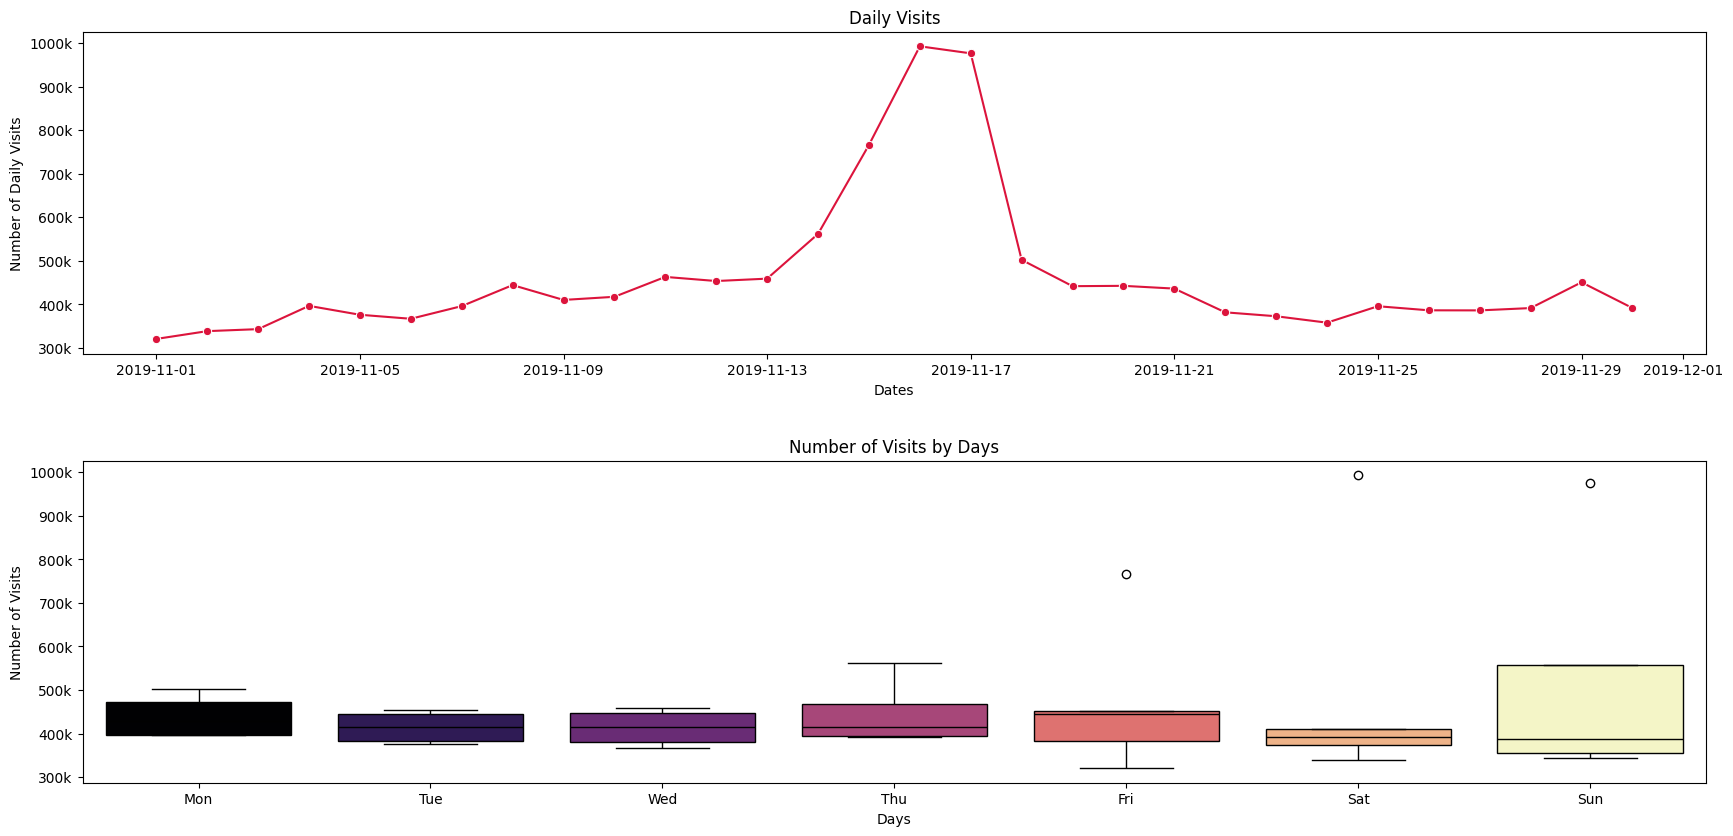

In [55]:
# Daily Visits
print('Daily Visits Statistics')
print('-'*50)
print(df_plot['Number_of_daily_visits'].describe())
print('-'*50)
print('Visit Statistics by Day')
print(df_plot.groupby('day_name')['Number_of_daily_visits'].describe())

#Line Plot
fig1 = plt.figure(figsize=(18,9))
ax1 = fig1.add_subplot(2,1,1)
sns.lineplot(x='event_date', y='Number_of_daily_visits', data=df_plot, ax=ax1, marker='o', color='crimson')
plt.xlabel('Dates')
plt.ylabel('Number of Daily Visits')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*1e-3:g}k'))
plt.title('Daily Visits')

#Box Plot
day_of_week = df_plot['event_date'].dt.dayofweek
ax2 = fig1.add_subplot(2,1,2)
sns.boxplot(x=day_of_week, y='Number_of_daily_visits', data=df_plot, ax=ax2,hue=day_of_week, palette='magma',legend=False)
plt.xlabel('Days')
plt.ylabel('Number of Visits')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*1e-3:g}k'))
plt.title('Number of Visits by Days')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
fig1.tight_layout(pad=3.0)

plt.savefig('daily_visits_combined.png', dpi=300, bbox_inches='tight')
plt.show()

Daily Visitors Statistics
--------------------------------------------------
count        30.00
mean    287,380.70
std      62,081.64
min     223,108.00
25%     254,358.50
50%     275,905.00
75%     289,868.25
max     487,501.00
Name: Number_of_daily_visitors, dtype: float64
--------------------------------------------------
Visitor Statistics by Day
           count       mean        std        min        25%        50%  \
day_name                                                                  
Friday      5.00 285,009.40  59,342.84 223,108.00 249,401.00 286,053.00   
Monday      4.00 286,290.50  26,325.43 257,613.00 271,112.25 284,006.00   
Saturday    5.00 299,102.80 105,926.17 234,685.00 249,362.00 255,497.00   
Sunday      4.00 311,103.00 118,806.29 240,187.00 240,441.25 258,362.00   
Thursday    4.00 282,222.00  22,659.37 253,979.00 272,735.75 283,033.50   
Tuesday     4.00 272,914.25  18,424.67 252,527.00 259,885.25 274,166.00   
Wednesday   4.00 272,685.25  18,629.14 256,546.

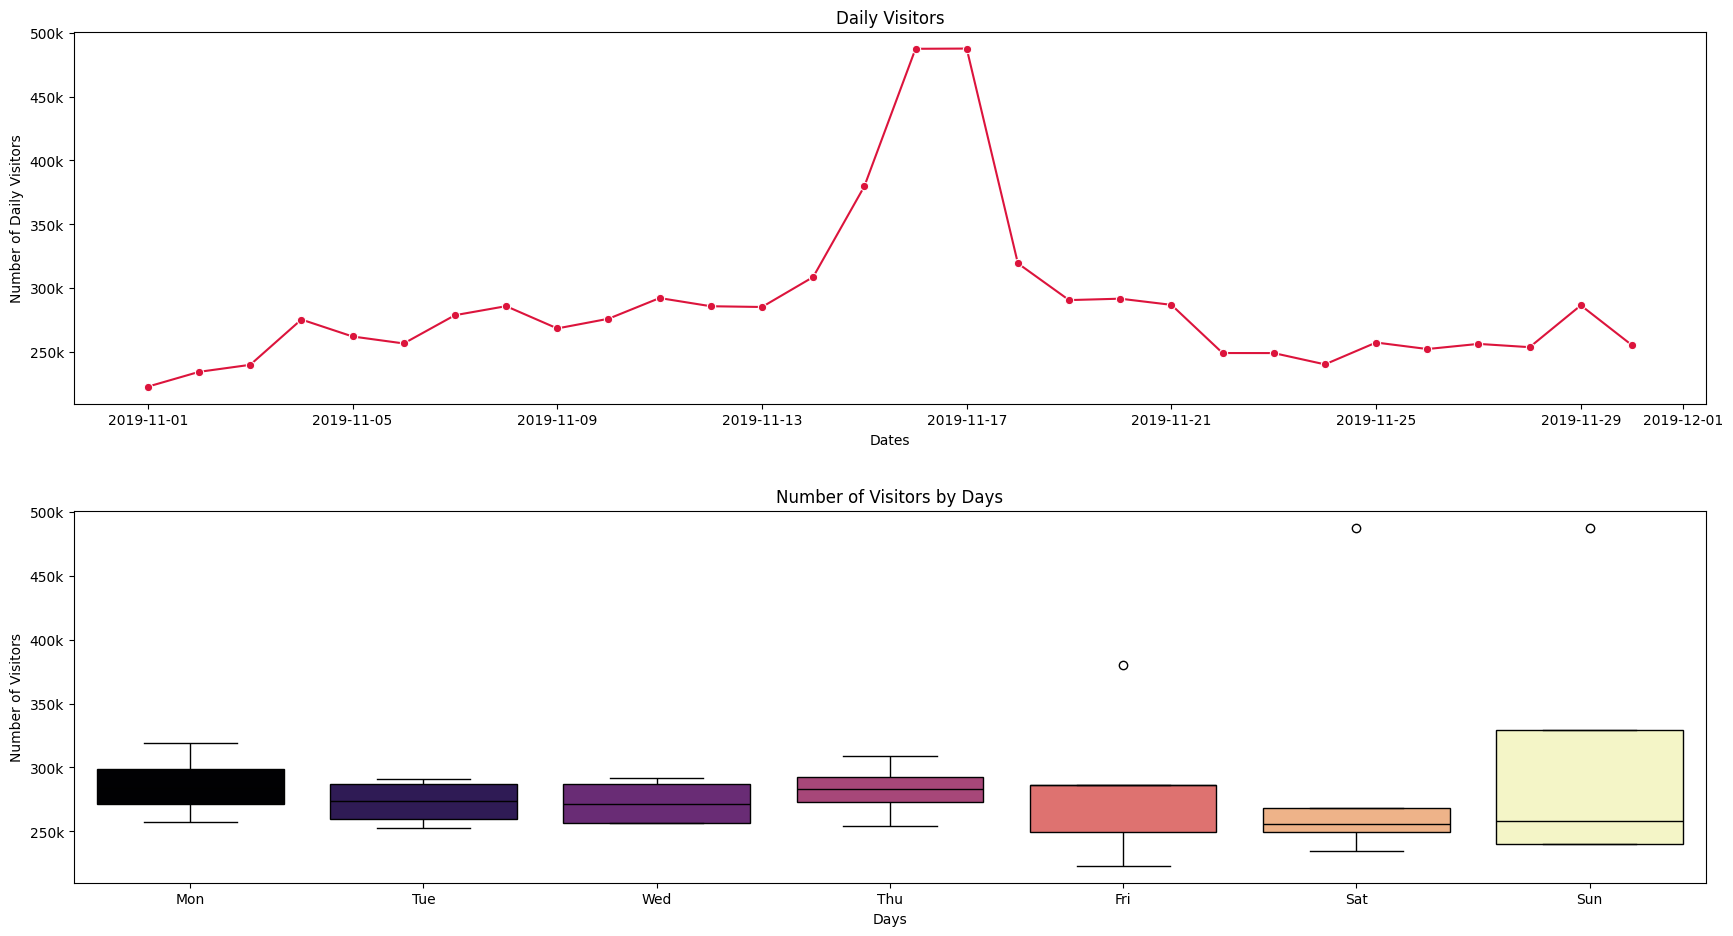

In [56]:
#Daily Visitors
print('Daily Visitors Statistics')
print('-'*50)
print(df_plot['Number_of_daily_visitors'].describe())
print('-'*50)
print('Visitor Statistics by Day')
print(df_plot.groupby('day_name')['Number_of_daily_visitors'].describe())

#Line Plot
fig2 = plt.figure(figsize=(18,10))
ax1 = fig2.add_subplot(2,1,1)
sns.lineplot(x='event_date', y='Number_of_daily_visitors', data=df_plot, ax=ax1, marker='o', color='crimson')
plt.xlabel('Dates')
plt.ylabel('Number of Daily Visitors')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*1e-3:g}k'))
plt.title('Daily Visitors')

#Box Plot
day_of_week = df_plot['event_date'].dt.dayofweek
ax2 = fig2.add_subplot(2,1,2)
sns.boxplot(x=day_of_week, y='Number_of_daily_visitors', data=df_plot, ax=ax2,hue=day_of_week, palette='magma',legend=False)
plt.xlabel('Days')
plt.ylabel('Number of Visitors')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*1e-3:g}k'))
plt.title('Number of Visitors by Days')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
fig2.tight_layout(pad=3.0)

plt.savefig('daily_visitors_combined.png', dpi=300, bbox_inches='tight')
plt.show()

Daily Conversion Rate Statistics (%)
--------------------------------------------------
count   30.00
mean     6.31
std      2.73
min      0.00
25%      5.64
50%      6.27
75%      6.57
max     18.97
Name: conversion_rate, dtype: float64
--------------------------------------------------
Conversion Statistics by Day
           count  mean  std  min  25%  50%  75%   max
day_name                                             
Friday      5.00  5.25 2.98 0.00 5.79 6.33 7.00  7.12
Monday      4.00  6.03 0.62 5.38 5.61 5.98 6.40  6.78
Saturday    5.00  6.41 0.67 5.55 5.96 6.45 6.88  7.19
Sunday      4.00  9.34 6.44 5.48 6.21 6.46 9.59 18.97
Thursday    4.00  5.55 1.10 3.94 5.33 6.00 6.22  6.28
Tuesday     4.00  5.88 0.71 5.01 5.49 5.96 6.35  6.61
Wednesday   4.00  5.94 0.86 4.91 5.45 5.98 6.47  6.90


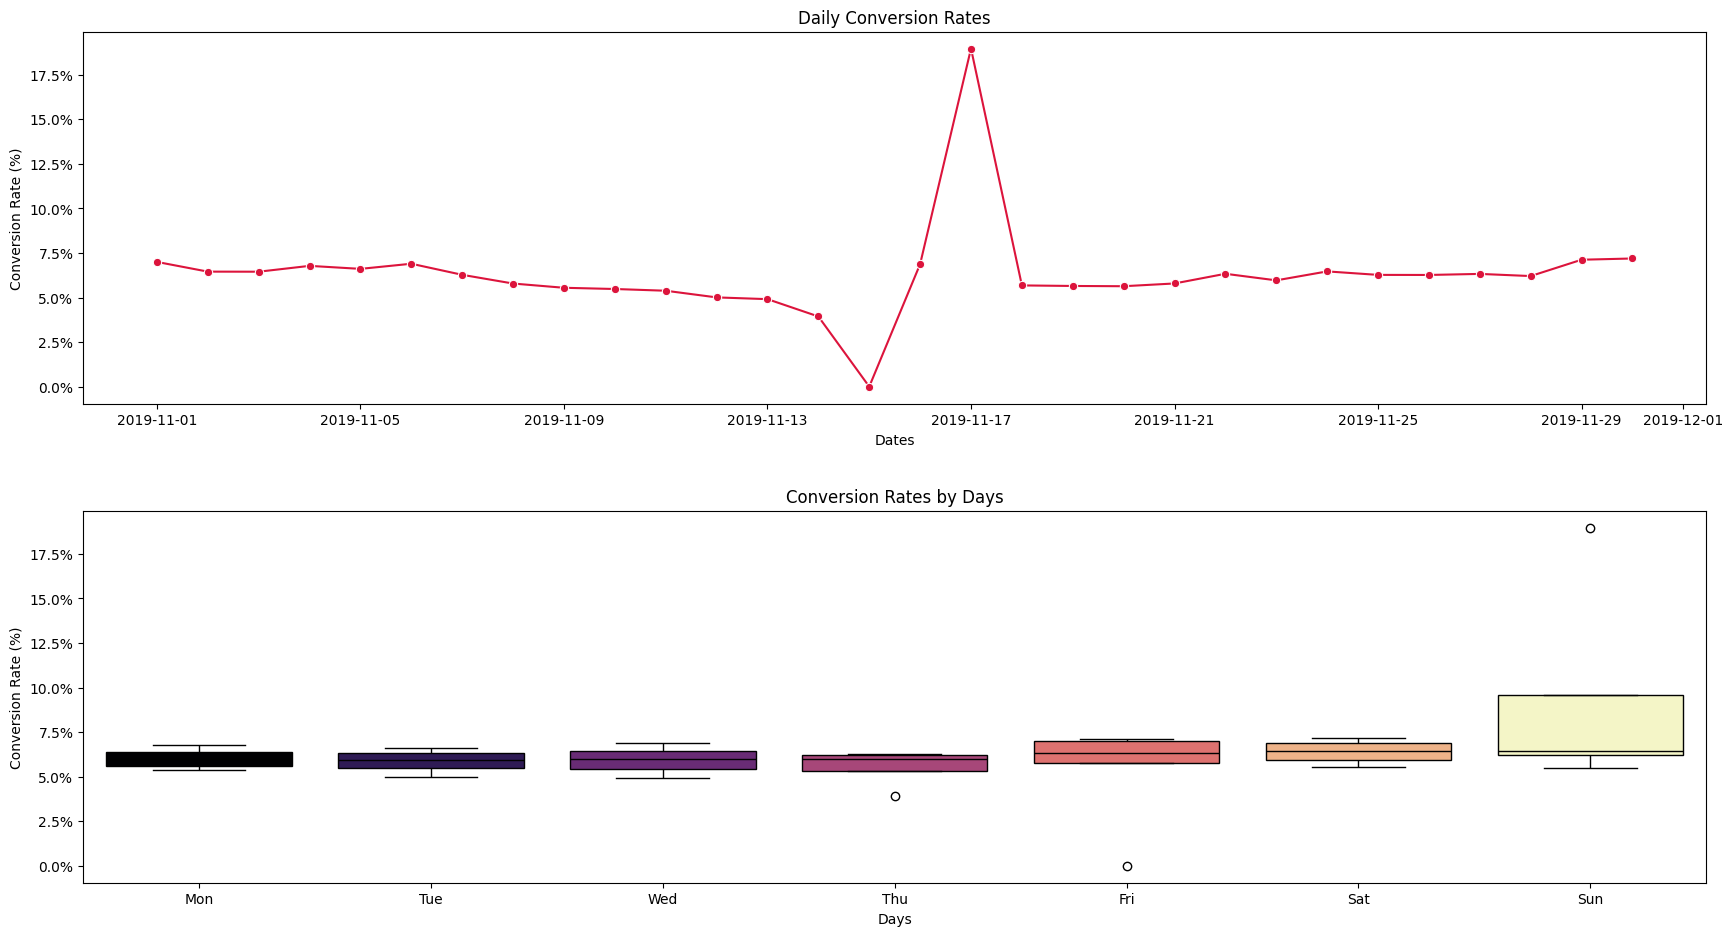

In [57]:
#Conversion Rates
print('Daily Conversion Rate Statistics (%)')
print('-'*50)
print(df_plot['conversion_rate'].describe())
print('-'*50)
print('Conversion Statistics by Day')
print(df_plot.groupby('day_name')['conversion_rate'].describe())

# Line Plot
fig3 = plt.figure(figsize=(18,10))
ax1 = fig3.add_subplot(2,1,1)
sns.lineplot(x='event_date', y='conversion_rate', data=df_plot, ax=ax1, marker='o', color='crimson')
ax1.set_xlabel('Dates')
ax1.set_ylabel('Conversion Rate (%)')
ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))
ax1.set_title('Daily Conversion Rates')

# Box Plot
ax2 = fig3.add_subplot(2,1,2)
day_of_week = df_plot['event_date'].dt.dayofweek
sns.boxplot( x=day_of_week,y='conversion_rate', data=df_plot, ax=ax2, hue=day_of_week, palette='magma', legend=False)
ax2.set_xlabel('Days')
ax2.set_ylabel('Conversion Rate (%)')
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))
ax2.set_title('Conversion Rates by Days')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

fig3.tight_layout(pad=3.0)

plt.savefig('daily_conversion_combined.png', dpi=300, bbox_inches='tight')
plt.show()

In [58]:
#summary table for category overview

# Summary table for all activities (Views, Users, Sessions)
cat_activity = df_final.groupBy("category").agg(
    fn.count("category").alias("Number_of_views"),
    fn.countDistinct("user_id").alias("Number_of_users"),
    fn.countDistinct("user_session").alias("Number_of_sessions")
)

# Summary table for sales only
# Filtering first in Spark is highly efficient
cat_sales = df_final.filter(fn.col("event_type") == "purchase") \
    .groupBy("category").agg(
        fn.count("category").alias("Number_of_purchase"),
        fn.sum("price").alias("Amount_of_purchase"),
        fn.mean("price").alias("Average_purchase_amount"),
        fn.countDistinct("user_session").alias("Number_of_sessions_with_purchase"),
        fn.countDistinct("user_id").alias("Number_of_shoppers")
    )

# Join, Fill NULLs, and Calculate Conversion Rate
category_summary = cat_activity.join(cat_sales, on="category", how="left").fillna(0)

category_summary = category_summary.withColumn(
    "Conversion_rate",
    (fn.col("Number_of_purchase") / fn.col("Number_of_sessions")) * 100
)

category_summary_table = category_summary.toPandas()


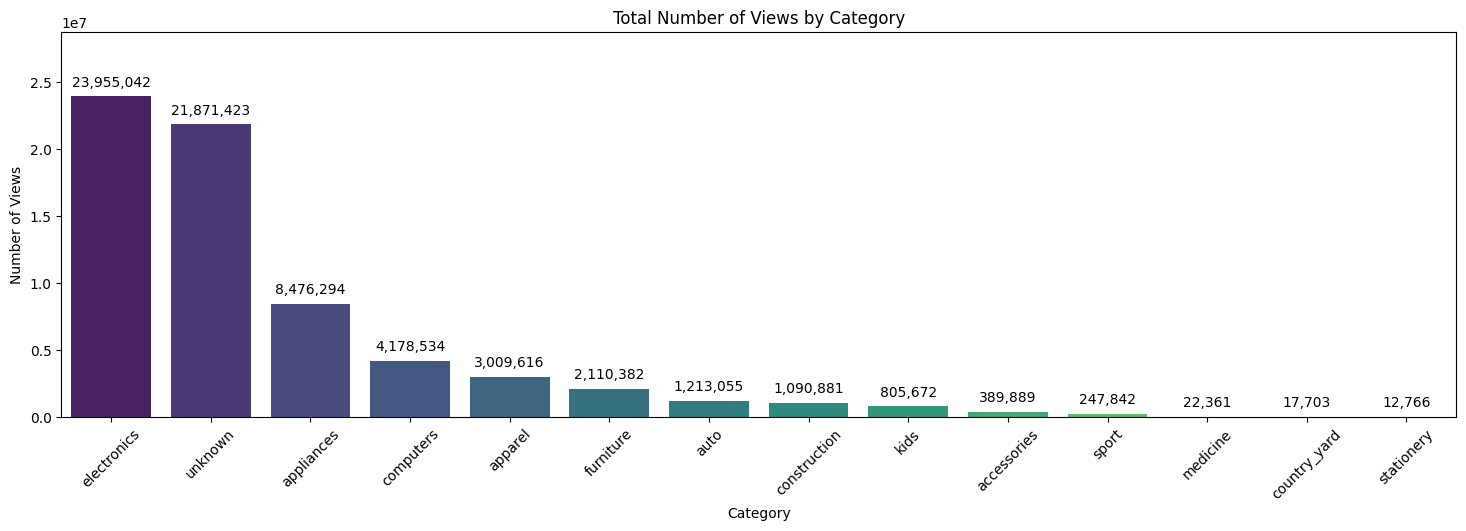

In [63]:
# Sorting the data so the bars go from highest to lowest
view_data = category_summary_table.sort_values('Number_of_views', ascending=False)
plt.figure(figsize=(18,5))
plot = sns.barplot(x='category', y='Number_of_views', data=view_data, hue='category', palette='viridis', legend=False)

for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'center',
                  xytext = (0, 10), textcoords = 'offset points')

plt.title('Total Number of Views by Category')
plt.xlabel('Category')
plt.ylabel('Number of Views')
plt.xticks(rotation=45) # Rotating labels for better readability
plt.ylim(0, view_data['Number_of_views'].max() * 1.2)
plt.savefig('Category_by_views.png', dpi=300, bbox_inches='tight')
plt.show()

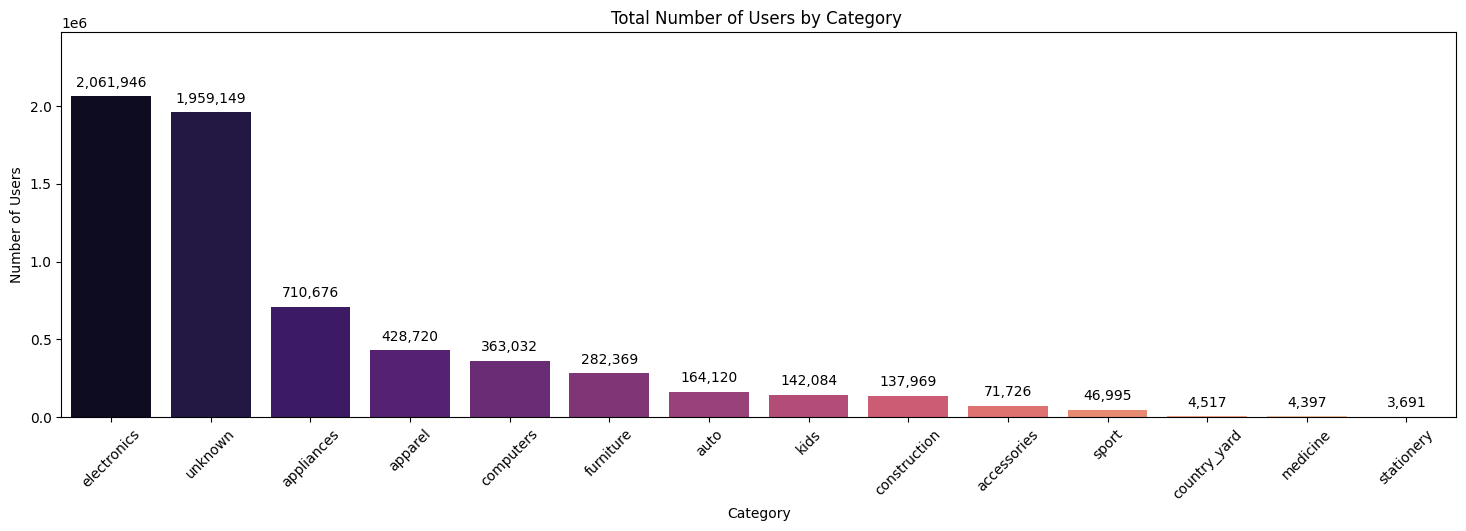

In [65]:
# Sorting the data by users
user_data = category_summary_table.sort_values('Number_of_users', ascending=False)

plt.figure(figsize=(18,5))
plot = sns.barplot(x='category', y='Number_of_users', data=user_data, hue='category', palette='magma', legend=False)

for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'center',
                  xytext = (0, 10), textcoords = 'offset points')

plt.title('Total Number of Users by Category ')
plt.xlabel('Category')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.ylim(0, user_data['Number_of_users'].max() * 1.2)
plt.savefig('Category_by_users.png', dpi=300, bbox_inches='tight')
plt.show()